In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.datasets import load_svmlight_file
import re
import itertools
from scipy import stats
from sklearn.model_selection import  train_test_split

In [2]:
sns.set_context('talk')

In [3]:
if os.path.split(os.getcwd())[-1] == 'notebooks': os.chdir(os.path.split(os.getcwd())[-2])
print(os.getcwd())

/home/fitzaudoen/apps/gas-sensor-analytics-demo


# Format of the .dat file

from https://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations#
"For processing purposes, the dataset is organized into ten batches, each containing the number of measurements per class and month indicated in the tables below. This reorganization of data was done to ensure having a sufficient and as uniformly distributed as possible number of experiments in each batch.

The dataset is organized in files, each representing a different batch. Within the files, each line represents a measurement. The first character (1-6) codes the analyte, followed by the concentration level:

1: Ethanol; 2: Ethylene; 3: Ammonia; 4: Acetaldehyde; 5: Acetone; 6: Toluene

The data format follows the same coding style as in libsvm format x:v, where x stands for the feature number and v for the actual value of the feature. For example, in
1;10.000000 1:15596.162100 2:1.868245 3:2.371604 4:2.803678 5:7.512213 â€¦ 128:-2.654529

The number 1 stands for the class number (in this case Ethanol), the gas concentration level was 10ppmv, and the remaining 128 columns list the actual feature values for each measurement recording organized as described above.

"

In [4]:
files = os.listdir(os.path.join(os.getcwd(),'data/raw/'))
files = [file for file in files if file.split('.')[-1] == 'dat']

In [5]:
print(files)

['batch1.dat', 'batch10.dat', 'batch2.dat', 'batch3.dat', 'batch4.dat', 'batch5.dat', 'batch6.dat', 'batch7.dat', 'batch8.dat', 'batch9.dat']


In [15]:
data = []
sample_no = 1
for batch in range(1,11):
    with open(os.path.join(os.getcwd(),'data/raw','batch{}.dat'.format(batch))) as file:  # the a opens it in append mode
        for line in file:
            line = line.strip()
            line = line.split(' ')
            #print(line)
            #print('\n')
            labels = [label for label in line[0].split(';')]
            line_data = [float(datum.split(':')[1]) for datum in line[1:]]
            line_data_feature_no = [str(int(datum.split(':')[0])) for datum in line[1:]]

            #for datum in line[1:]: data[int(datum.split(':')[0])] = float(datum.split(':')[1])  
            #print(line_data_labels)
            #print(line_data)
            #print('\n')
            #print('\n')
            if len(labels) !=2: print('not two labels')
            if len(line_data_feature_no ) != 128: print('not 128 features')
            #if line_data_feature_no != list(range(1,129)): print('lables misordered')

            data.append([batch]+labels+[sample_no]+line_data)
            sample_no+=1

# Add mnemonic ID labels and feature names

In [16]:
chemical_names = {'1':'Ethanol', '2':'Ethylene', '3':'Ammonia', '4':'Acetaldehyde', '5':'Acetone', '6':'Toluene'}

In [17]:
feature_names = ['s{sensor_id}_f{feature_id}'.format(sensor_id=sensor_id,feature_id=feature_id) for
                sensor_id, feature_id in itertools.product(range(1,9),range(1,17))]

In [18]:
columns = ['Batch_ID','Gas_ID','Gas_Conc','sample_no']  + feature_names
df = pd.DataFrame(data,columns=columns)

In [19]:
for k, v in chemical_names.items():
    df.loc[df.Gas_ID == k,'Gas_ID'] = v

# Data Exploration

In [20]:
melt_df = df.melt(id_vars=(['Batch_ID','Gas_ID','Gas_Conc']),var_name = 'sensor_feature', value_name ='sensor_value')

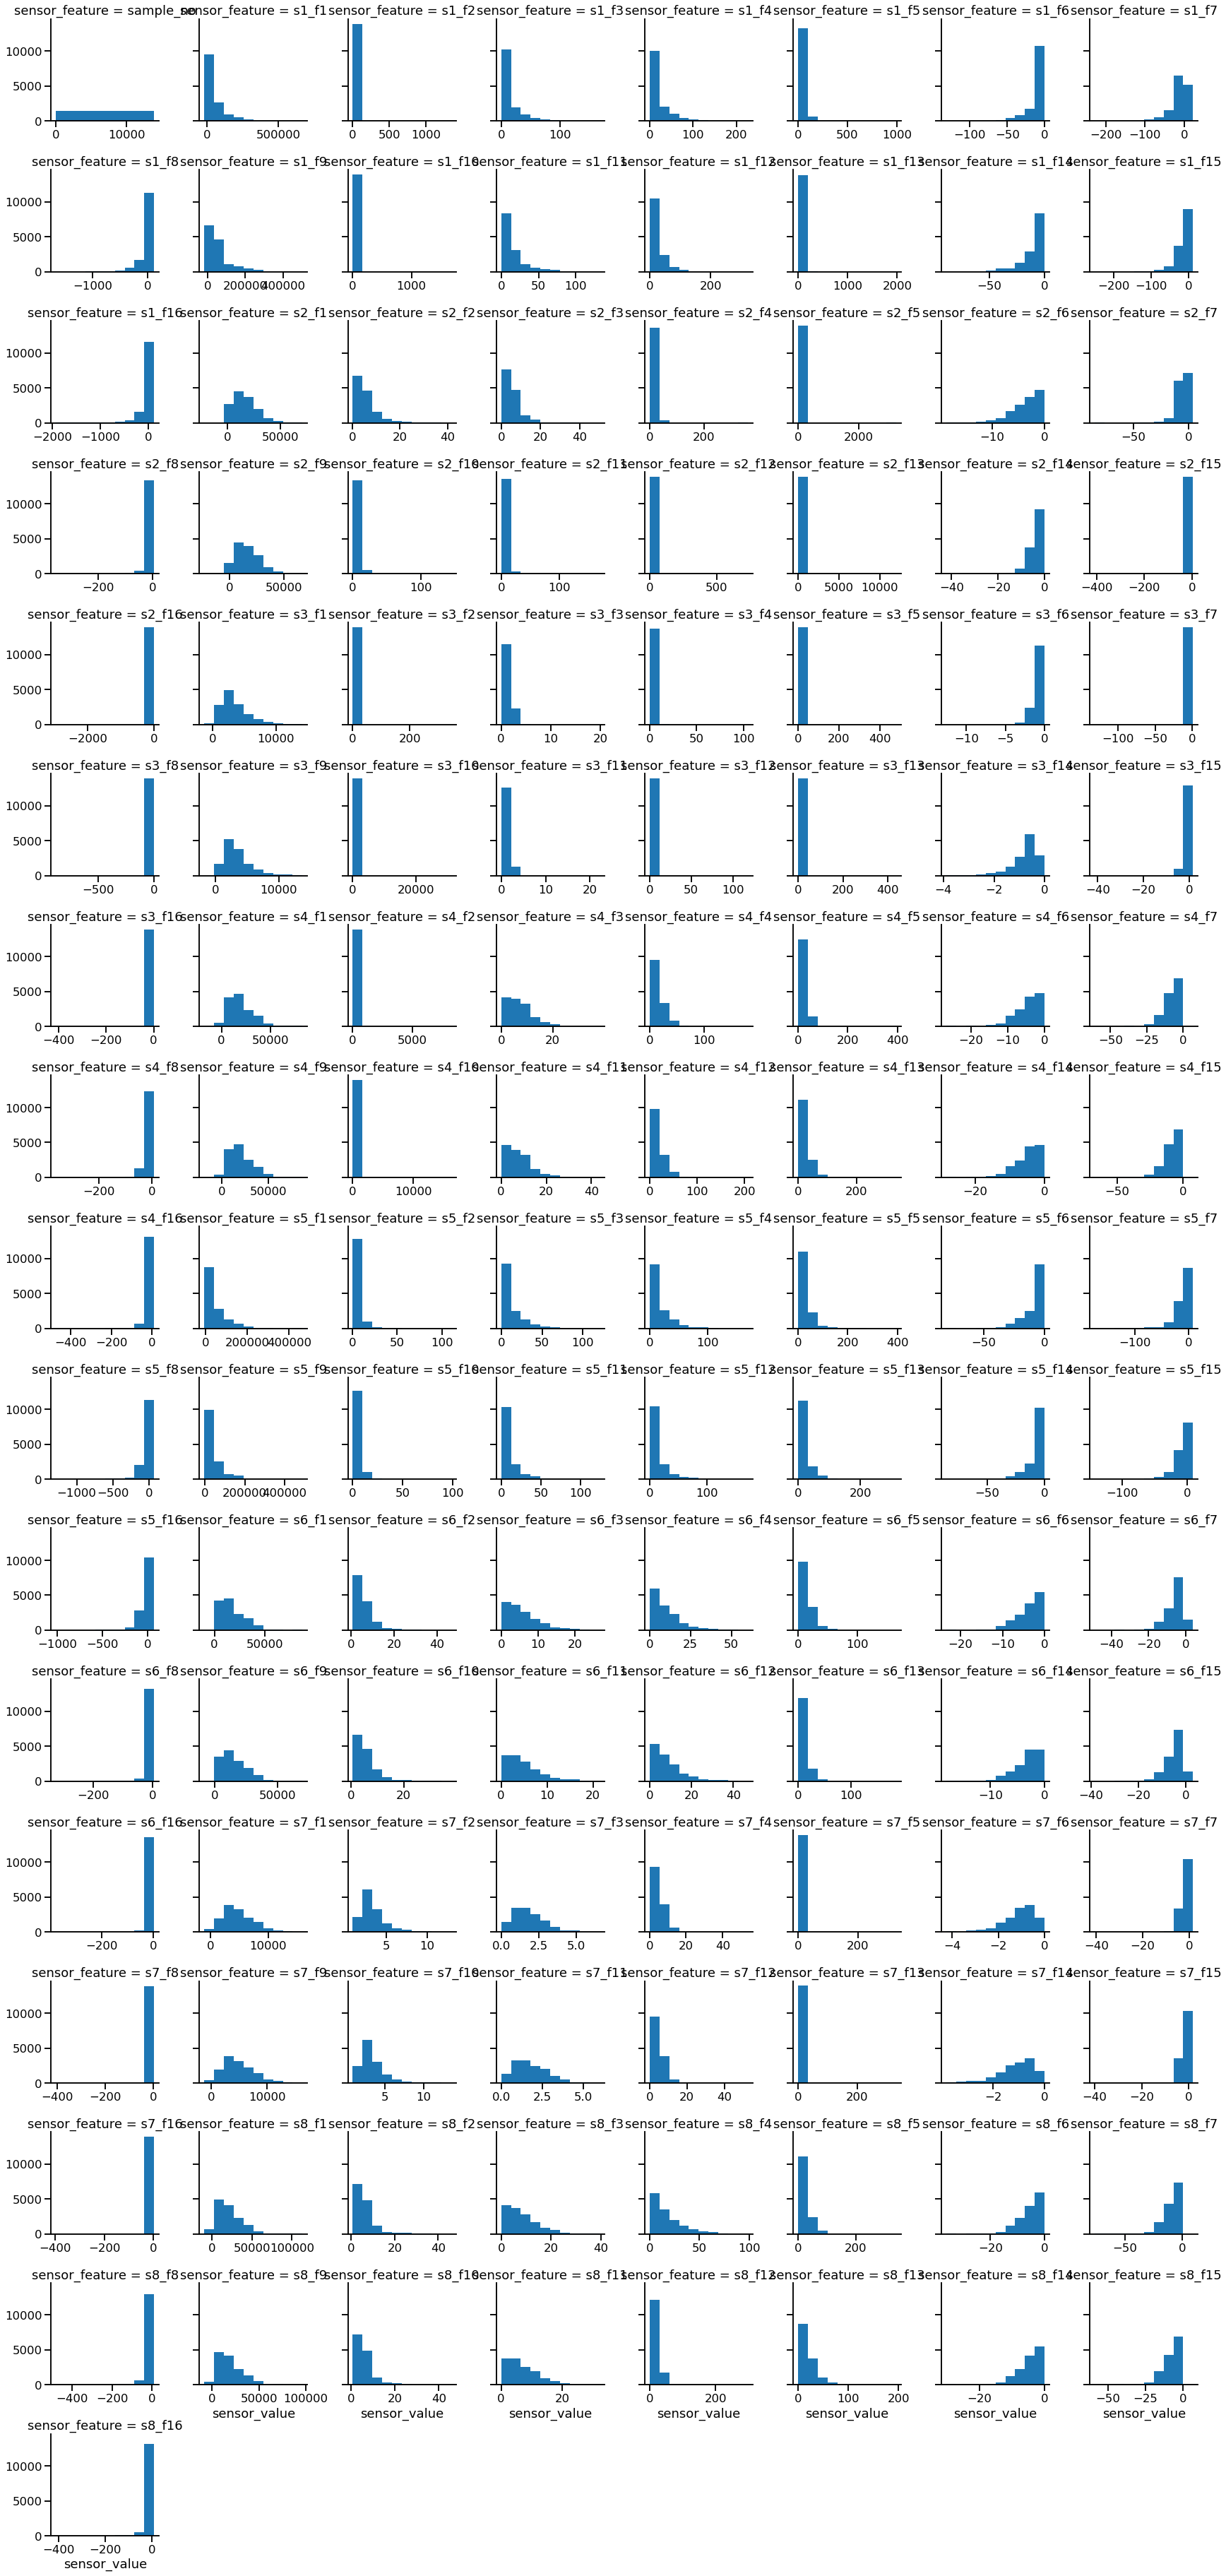

In [21]:
g = sns.FacetGrid(melt_df, col='sensor_feature', col_wrap=8, sharex=False)
g.map(plt.hist,'sensor_value')

(array([6.013e+03, 5.195e+03, 1.678e+03, 4.910e+02, 2.330e+02, 1.750e+02,
        8.600e+01, 2.500e+01, 1.200e+01, 1.000e+00]),
 array([ 0.53948  ,  4.3642875,  8.189095 , 12.0139025, 15.83871  ,
        19.6635175, 23.488325 , 27.3131325, 31.13794  , 34.9627475,
        38.787555 ]),
 <BarContainer object of 10 artists>)

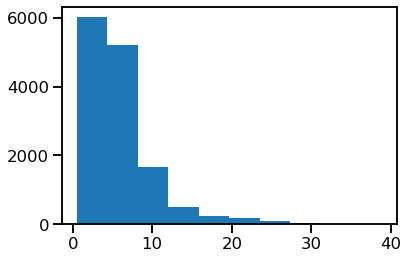

In [22]:
plt.hist(df.loc[df.s4_f10<40,'s4_f10'])

In [23]:
len(df.loc[df.s4_f10<40,'s4_f10'])/len(df.s4_f10)

0.9999281092739036

## Select Z value cut-off for outliers / presumed bad sensor readings

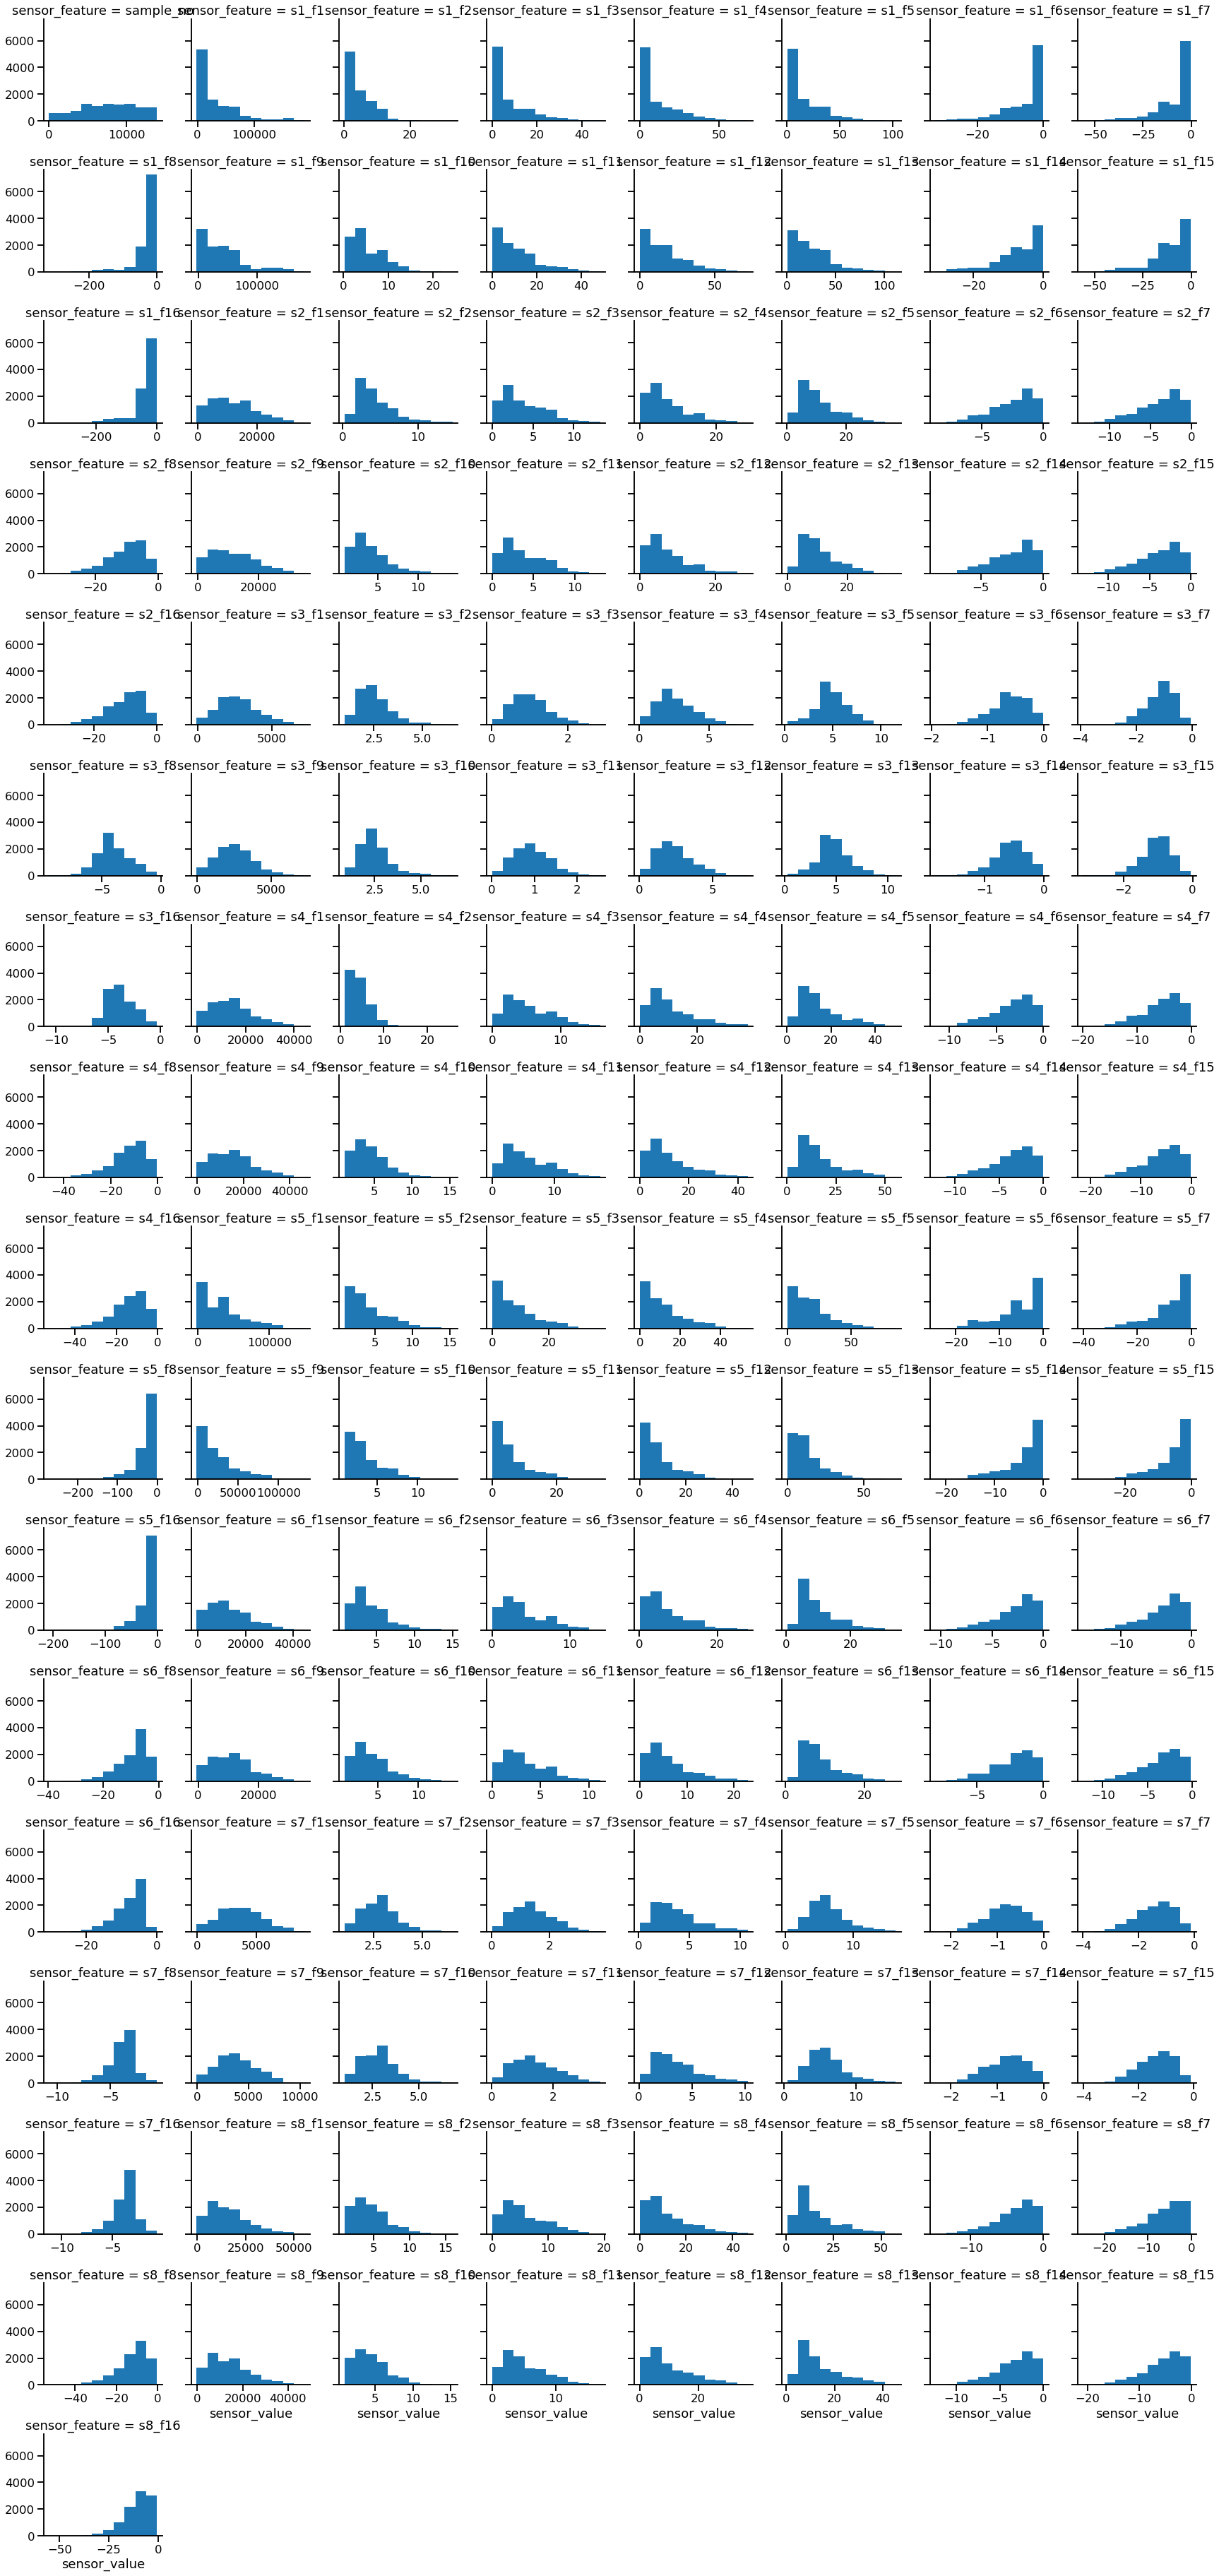

In [24]:
filter_df = df[(np.abs(stats.zscore(df.loc[:,feature_names])) < 2).all(axis=1)]
filter_melt_df = filter_df.melt(id_vars=(['Batch_ID','Gas_ID','Gas_Conc']),var_name = 'sensor_feature', value_name ='sensor_value')
g = sns.FacetGrid(filter_melt_df, col='sensor_feature', col_wrap=8, sharex=False)
g.map(plt.hist,'sensor_value')

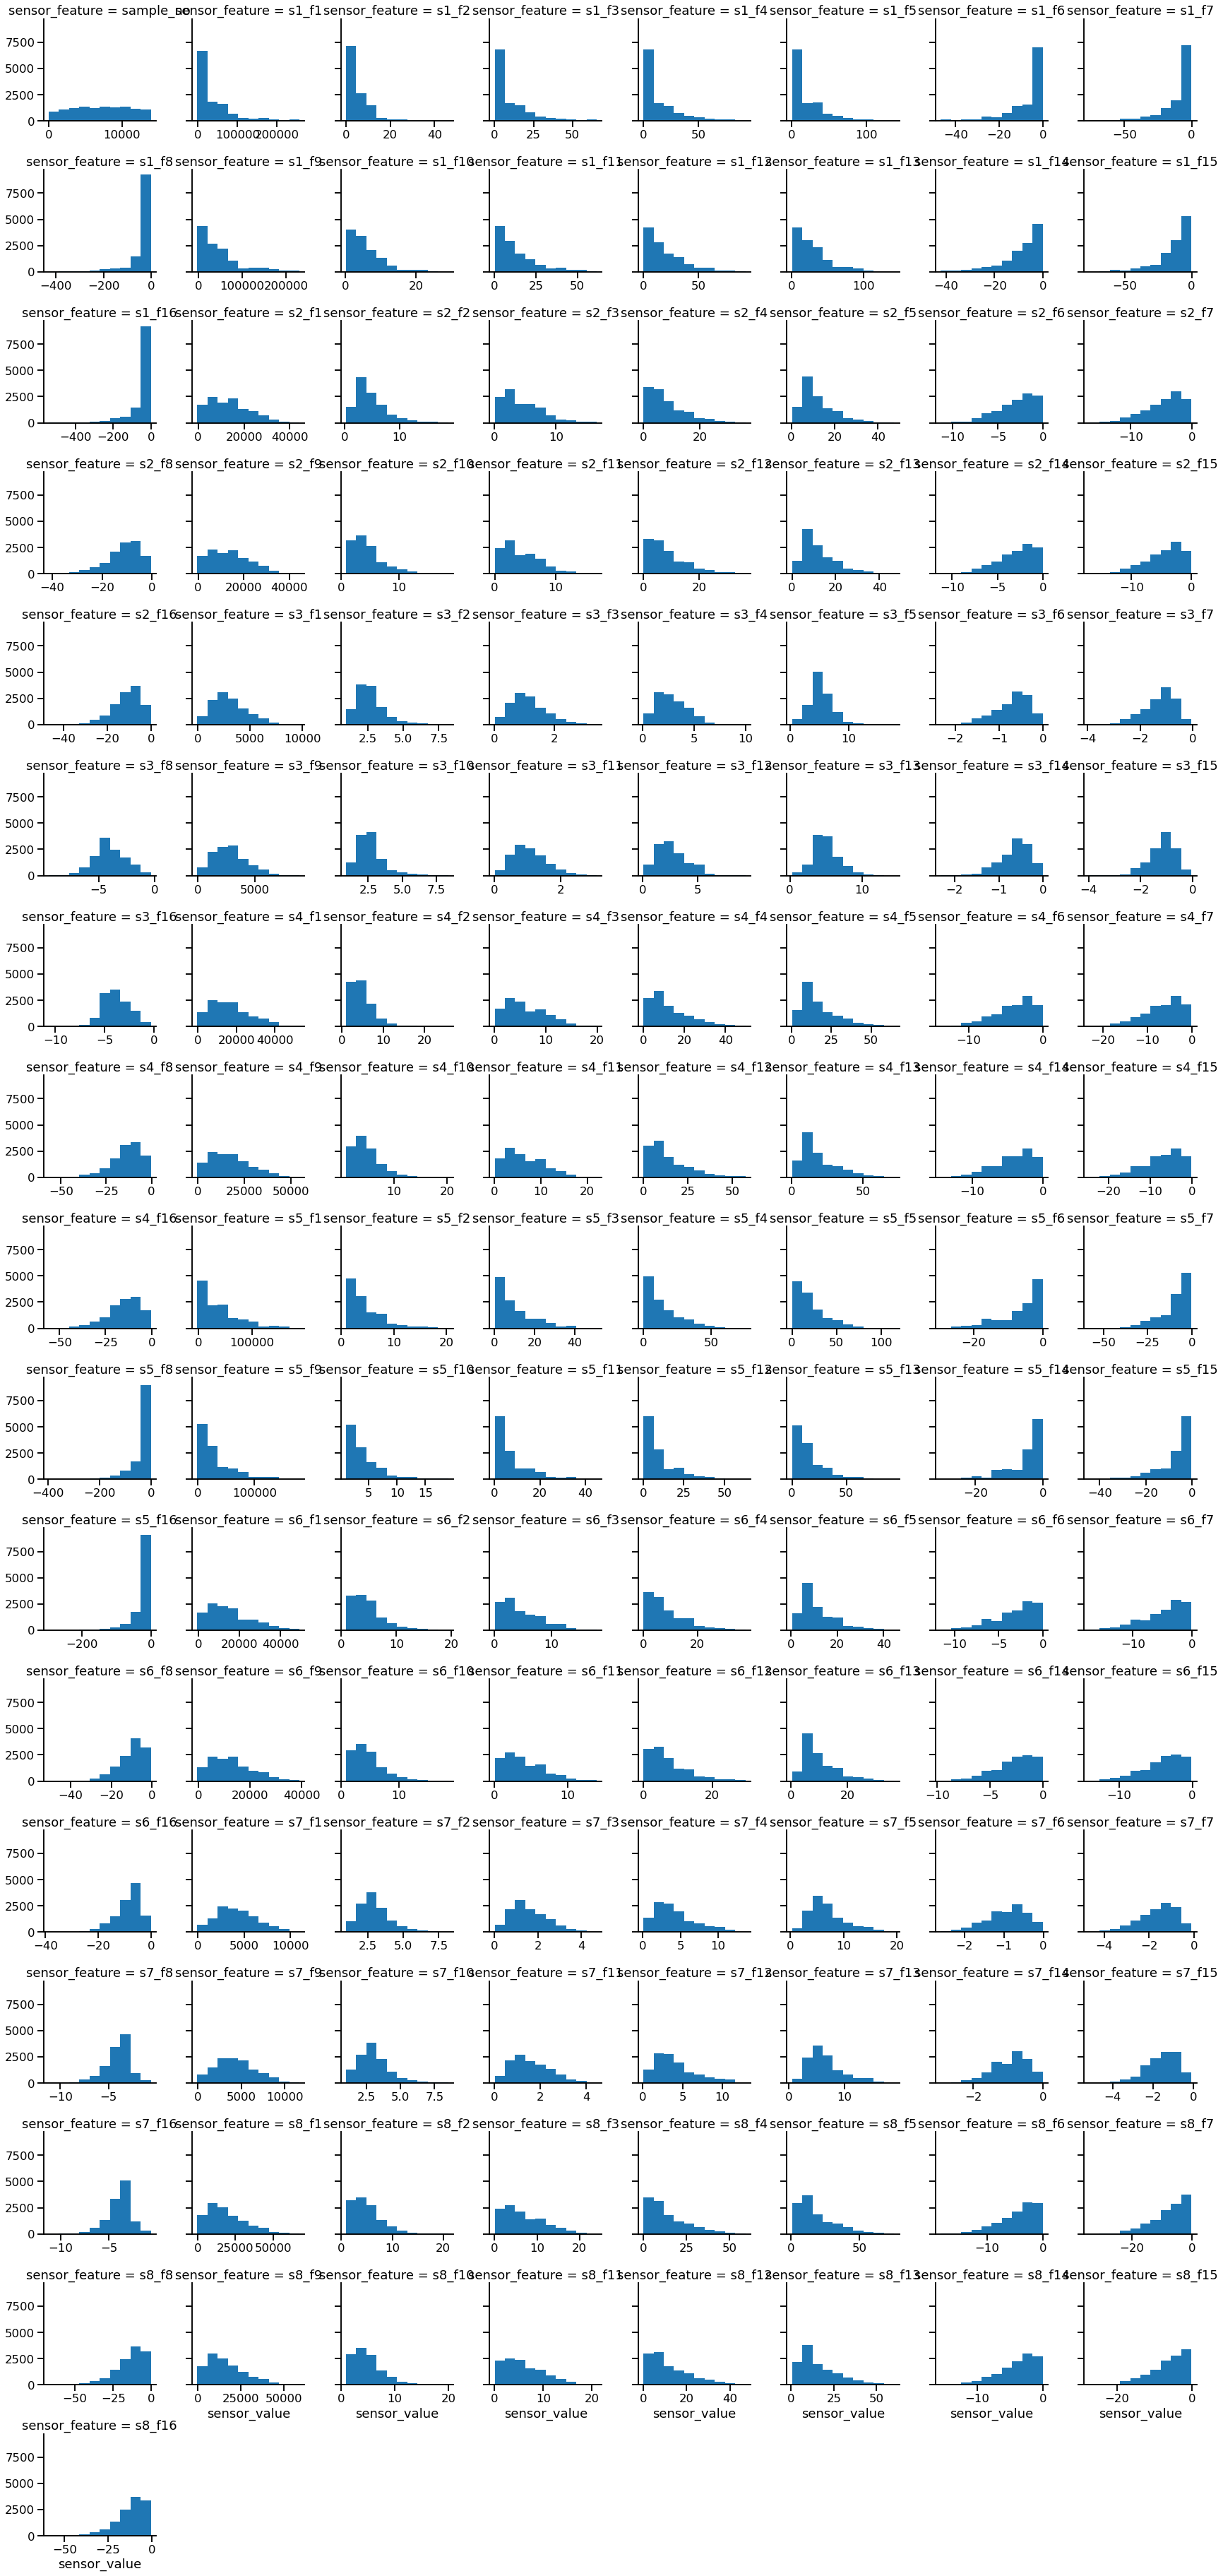

In [25]:
filter_df = df[(np.abs(stats.zscore(df.loc[:,feature_names])) < 3).all(axis=1)]
filter_melt_df = filter_df.melt(id_vars=(['Batch_ID','Gas_ID','Gas_Conc']),var_name = 'sensor_feature', value_name ='sensor_value')
g = sns.FacetGrid(filter_melt_df, col='sensor_feature', col_wrap=8, sharex=False)
g.map(plt.hist,'sensor_value')

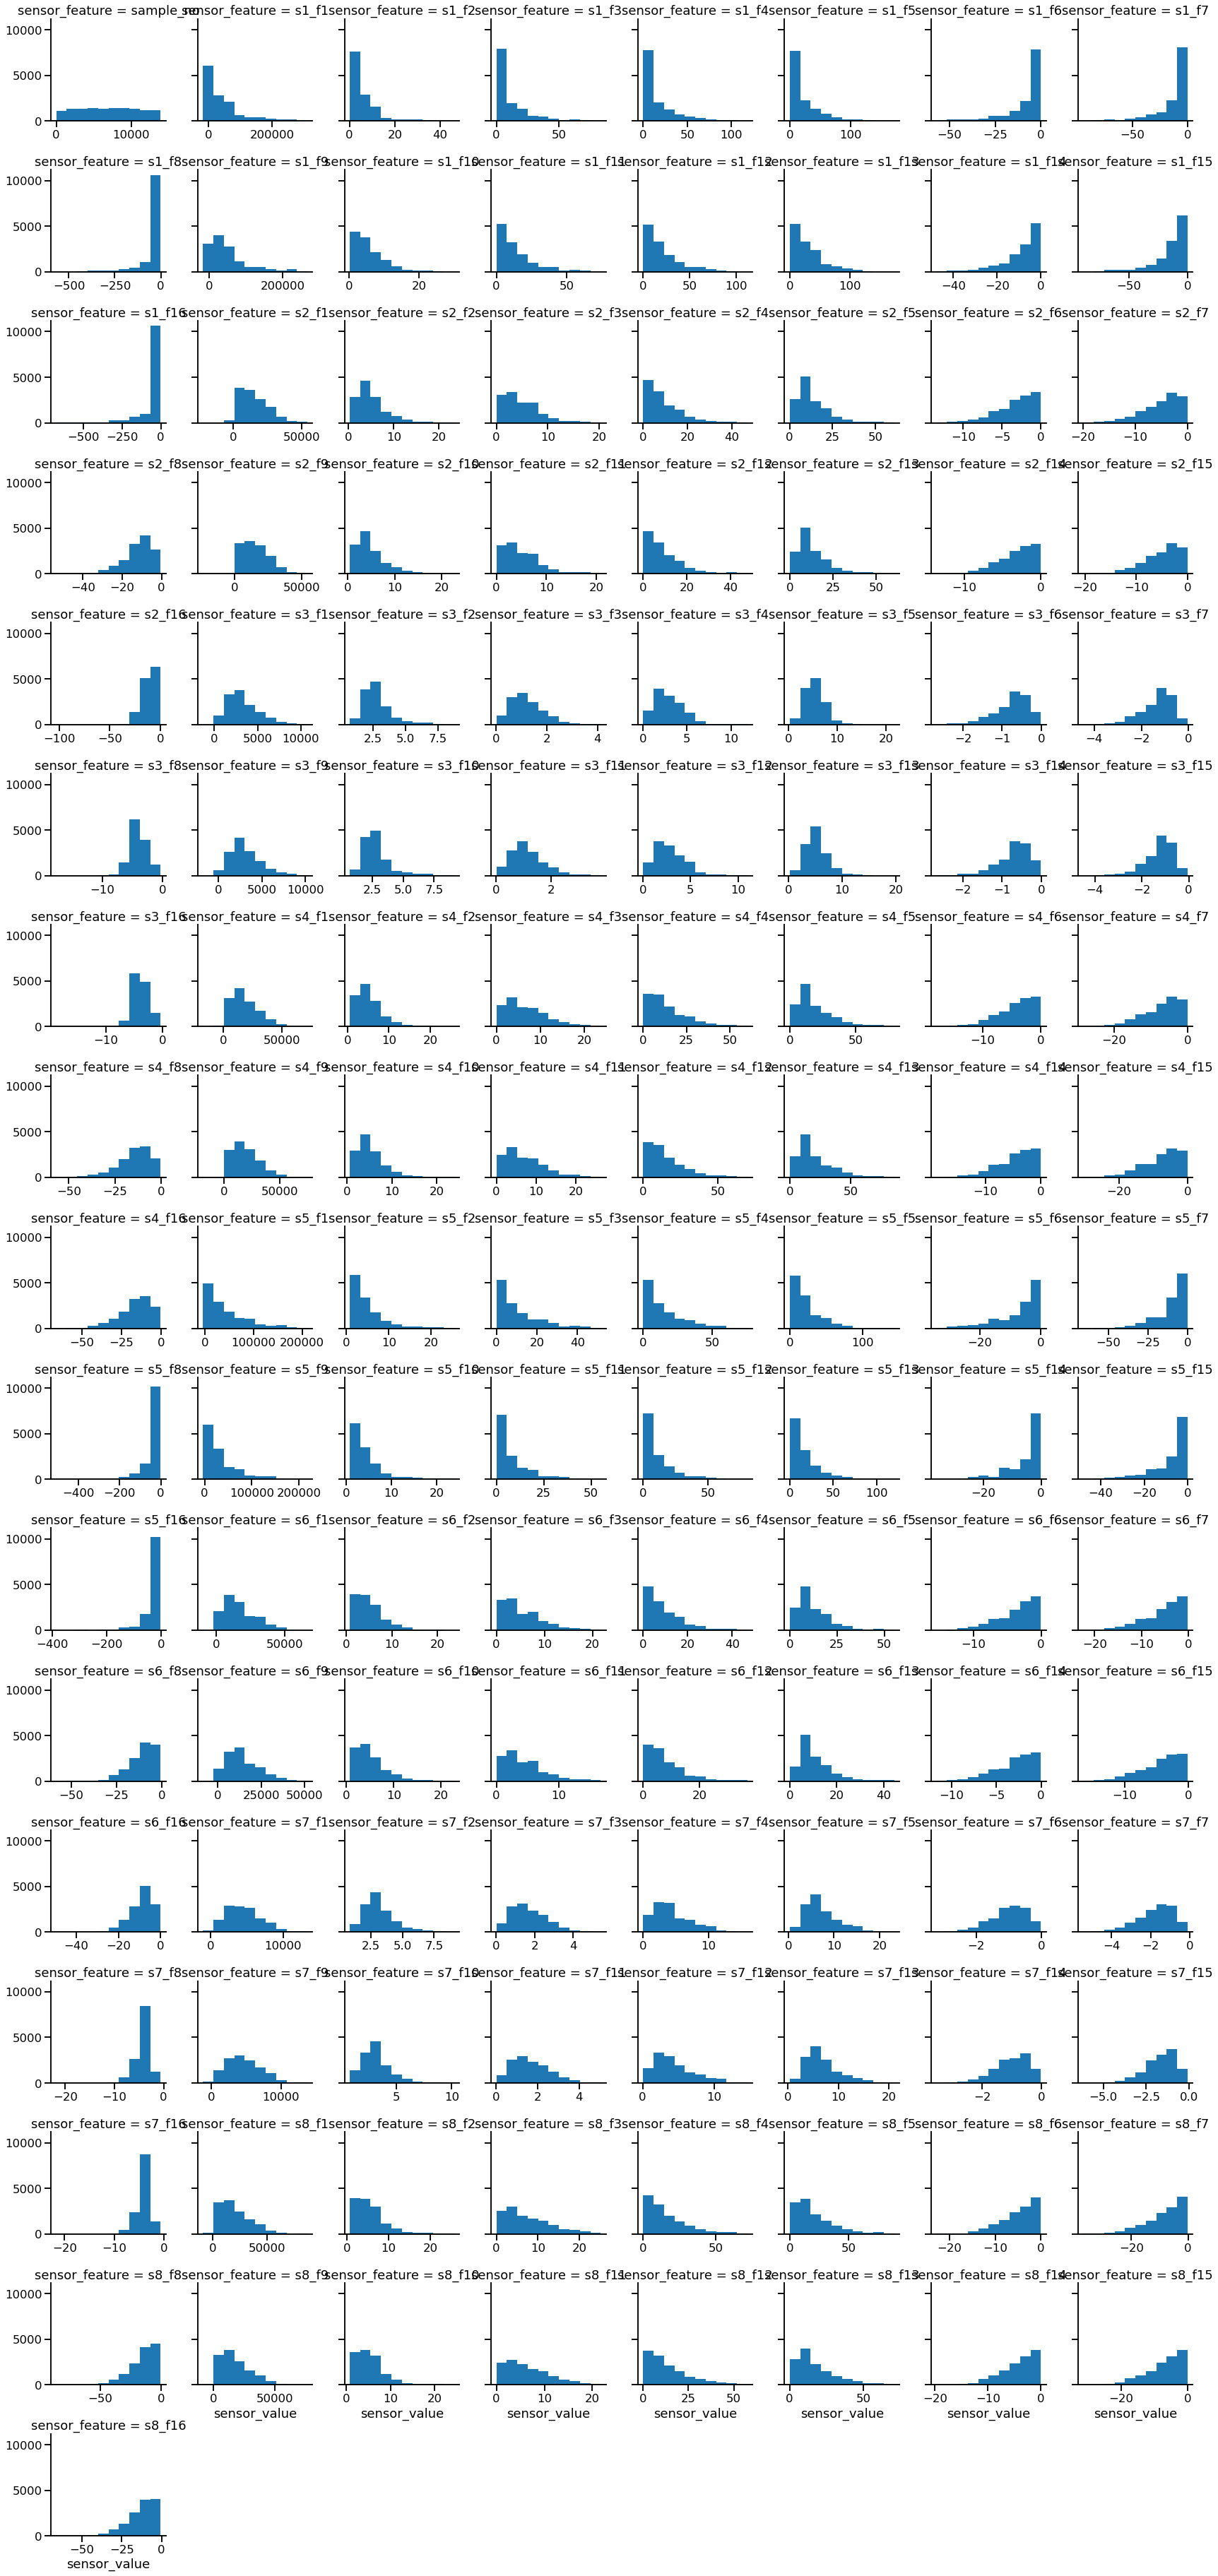

In [26]:
filter_df = df[(np.abs(stats.zscore(df.loc[:,feature_names])) < 4).all(axis=1)]
filter_melt_df = filter_df.melt(id_vars=(['Batch_ID','Gas_ID','Gas_Conc']),var_name = 'sensor_feature', value_name ='sensor_value')
g = sns.FacetGrid(filter_melt_df, col='sensor_feature', col_wrap=8, sharex=False)
g.map(plt.hist,'sensor_value')

In [27]:
melt_df.groupby('sensor_feature')['sensor_value'].apply(lambda x: stats.zscore)

sensor_feature
s1_f1        <function zscore at 0x7fc5a237bee0>
s1_f10       <function zscore at 0x7fc5a237bee0>
s1_f11       <function zscore at 0x7fc5a237bee0>
s1_f12       <function zscore at 0x7fc5a237bee0>
s1_f13       <function zscore at 0x7fc5a237bee0>
                            ...                 
s8_f6        <function zscore at 0x7fc5a237bee0>
s8_f7        <function zscore at 0x7fc5a237bee0>
s8_f8        <function zscore at 0x7fc5a237bee0>
s8_f9        <function zscore at 0x7fc5a237bee0>
sample_no    <function zscore at 0x7fc5a237bee0>
Name: sensor_value, Length: 129, dtype: object

In [28]:
df = df[(np.abs(stats.zscore(df.loc[:,feature_names])) < 2).all(axis=1)].copy()

## Split Data

In [29]:
train, testing = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)

In [30]:
cross_validation, test = train_test_split(testing, test_size=0.5, random_state=42, shuffle=True)

In [31]:
cross_validation

,Batch_ID,Gas_ID,Gas_Conc,sample_no,s1_f1,s1_f2,s1_f3,s1_f4,s1_f5,s1_f6,...,s8_f7,s8_f8,s8_f9,s8_f10,s8_f11,s8_f12,s8_f13,s8_f14,s8_f15,s8_f16
10676,10,Acetaldehyde,50.000000,10677,19645.6079,4.638829,4.553167,6.377995,10.380011,-3.103048,...,-1.726612,-5.993299,3082.9048,2.197622,1.761476,4.821488,8.647357,-0.903230,-1.639943,-6.130121
8307,7,Acetone,200.000000,8308,6145.0537,2.839203,1.514583,2.305614,5.411852,-0.958806,...,-13.402674,-24.667639,28973.6347,4.814068,8.751160,15.497117,19.740037,-7.121960,-11.512648,-26.133500
11149,10,Ethylene,250.000000,11150,20289.0166,4.572847,5.327592,6.736475,10.060883,-3.220156,...,-14.110664,-29.069380,24440.6387,10.055652,9.861556,22.841508,28.529260,-6.654146,-11.657475,-21.674237
9100,7,Acetaldehyde,30.000000,9101,5635.1728,2.111819,1.296212,2.374517,5.403643,-0.973331,...,-2.440946,-5.958391,6722.9145,2.556107,2.402105,4.877323,7.578621,-1.441861,-2.182360,-5.655738
867,2,Ethylene,75.000000,868,6007.7529,1.519762,1.414346,1.830381,2.256096,-1.103232,...,-8.395792,-9.271753,16852.2575,13.105434,6.779582,14.952266,16.557474,-4.162406,-6.572508,-7.440060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12570,10,Toluene,60.000000,12571,24757.4448,7.942815,5.526620,7.459107,10.709785,-5.534816,...,-5.233796,-11.099459,6554.6900,3.215362,2.291944,5.111702,8.788730,-2.871395,-4.704929,-8.983679
12996,10,Acetaldehyde,150.000000,12997,27987.2432,7.034359,6.340209,8.201822,11.153756,-5.271252,...,-1.804106,-5.000518,7415.8987,3.199874,3.304155,7.724189,10.975063,-1.043259,-1.789913,-4.469323
5351,6,Acetone,50.000000,5352,57941.0273,2.980295,9.652146,14.030109,33.145971,-8.582202,...,-2.799910,-8.105584,9574.3189,2.301058,1.860834,3.313898,5.517420,-1.679725,-2.509792,-6.632986
8832,7,Acetaldehyde,10.000000,8833,2553.4717,1.462204,0.936059,1.937872,5.388044,-0.497611,...,-1.176192,-4.051929,3318.3872,1.771477,1.720858,3.706182,6.528624,-0.673563,-1.090266,-3.830294


In [32]:
test

,Batch_ID,Gas_ID,Gas_Conc,sample_no,s1_f1,s1_f2,s1_f3,s1_f4,s1_f5,s1_f6,...,s8_f7,s8_f8,s8_f9,s8_f10,s8_f11,s8_f12,s8_f13,s8_f14,s8_f15,s8_f16
10856,10,Toluene,1.000000,10857,2228.4517,1.517962,1.751999,2.905618,6.071533,-0.254218,...,-0.489166,-4.515348,183.0127,1.073662,0.781626,2.274258,5.273146,-0.097984,-0.468366,-4.411239
8536,7,Acetone,80.000000,8537,3405.1001,2.171993,0.738349,1.091530,4.186612,-0.409103,...,-5.032772,-12.040344,16693.4643,3.849915,3.487383,4.341746,8.391011,-2.862539,-4.409626,-11.494159
7870,7,Ammonia,50.000000,7871,23.7513,1.031672,0.030742,0.246015,2.309926,-0.041451,...,-0.641489,-3.821904,1348.4472,1.249354,0.377102,0.709232,3.435593,-0.240393,-0.540374,-3.607825
12794,10,Ethanol,250.000000,12795,94603.7656,4.081874,24.943537,37.083471,66.995047,-5.261475,...,-3.340375,-7.211535,23709.9878,5.791308,8.792435,17.052393,22.849002,-2.014031,-3.265257,-7.226592
7324,7,Ammonia,140.000000,7325,1361.8925,1.884981,0.360015,0.757328,3.235272,-0.296770,...,-2.433826,-6.589678,6897.7100,2.173967,2.283458,3.597953,6.388529,-1.362502,-2.098792,-6.252241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,3,Ammonia,275.000000,2772,16017.0918,4.825957,4.033205,5.536347,5.969744,-2.719748,...,-5.657524,-8.450958,12973.4873,2.692154,4.405721,6.589676,7.873566,-3.066015,-4.787333,-6.810469
8309,7,Toluene,65.000000,8310,3950.9282,2.347138,0.798085,1.268838,3.774882,-0.640586,...,-5.349451,-12.220935,14016.4180,3.256213,4.085121,6.482566,9.940409,-3.167875,-5.086931,-12.605749
9931,9,Ethanol,10.000000,9932,19202.5381,4.542054,8.440546,13.769757,19.414160,-2.739760,...,-1.948559,-4.840249,5586.2898,2.972504,5.437055,15.413424,19.524892,-1.100395,-1.712251,-4.423881
11216,10,Ethanol,2.500000,11217,4343.8091,2.175777,3.516095,5.698433,7.599660,-0.377924,...,-0.476423,-4.214856,845.6878,1.321330,3.489850,11.630574,17.293958,-0.186377,-0.440096,-3.073946


# Explore Log Transform

NameError: name 'train' is not defined